In [173]:
import copy

class GridWorld:
    def __init__(self):
        self.filed_type = { #dict 
            "N": 0,  # 通常
            "G": 1,  # ゴール
            "W": 2,  # 壁
        #    "T": 3,  # トラップ
        }
        self.actions = { #dict
            "UP": 0,
            "DOWN": 1,
            "LEFT": 2,
            "RIGHT": 3
        }
        self.map = [[0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 2, 0, 2, 0, 0, 2, 2, 0],
                    [2, 0, 2, 0, 2, 2, 2, 2, 0, 0],
                    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
                    [2, 2, 2, 2, 0, 2, 0, 2, 0, 0],
                    [0, 0, 0, 0, 0, 2, 0, 2, 0, 0],
                    [0, 2, 2, 2, 2, 2, 0, 2, 0, 0],
                    [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
                    [0, 0, 2, 0, 0, 0, 0, 2, 0, 1]]

        self.start_pos = (0, 0)   # エージェントのスタート地点(x, y) ()なしでもタプルと判定される
        self.agent_pos = copy.deepcopy(self.start_pos)  # エージェントがいる地点

    def step(self, action): #step関数が呼ばれた時点でactinonは[UP,DOWN, LEFT, RIGHT]のいずれかを指定済み
        """
            行動の実行
            状態, 報酬、ゴールしたかを返却
        """
        to_x, to_y = copy.deepcopy(self.agent_pos) #現在座標

        # 移動可能かどうかの確認。移動不可能であれば、ポジションはそのままにマイナス報酬
        if self._is_possible_action(to_x, to_y, action) == False:
            return self.agent_pos, None, False #報酬はNone.これはmain側でNoneなら壁である判定をさせる

        if action == self.actions["UP"]:
            to_y += -1
        elif action == self.actions["DOWN"]:
            to_y += 1
        elif action == self.actions["LEFT"]:
            to_x += -1
        elif action == self.actions["RIGHT"]:
            to_x += 1

        is_goal = self._is_end_episode(to_x, to_y) # エピソードの終了の確認
        reward = self._compute_reward(to_x, to_y)
        self.agent_pos = to_x, to_y #ここで座標変更(移動)
        return self.agent_pos, reward, is_goal #返すのは現在座標、即時報酬、ゴール判定

    def _is_end_episode(self, x, y):
        """
            x, yがエピソードの終了かの判定。
        """
        #x, yはマップの左上のマスを原点として右と下がそれぞれの正の方向なので配列で扱うときはxとyは逆になる
        if self.map[y][x] == self.filed_type["G"]:      # ゴール
            return True
        #elif self.map[y][x] == self.filed_type["T"]:    # トラップ
        #    return True
        else:
            return False

    def _is_wall(self, x, y):
        """
            x, yが壁かどうかの確認
        """
        if self.map[y][x] == self.filed_type["W"]:
            return True
        else:
            return False

    def _is_possible_action(self, x, y, action):
        """
            実行可能な行動かどうかの判定
        """
        to_x = x
        to_y = y

        if action == self.actions["UP"]:
            to_y += -1
        elif action == self.actions["DOWN"]:
            to_y += 1
        elif action == self.actions["LEFT"]:
            to_x += -1
        elif action == self.actions["RIGHT"]:
            to_x += 1

        if len(self.map) <= to_y or 0 > to_y: #to_yが取りうる値は[0, 9]なのでそうでなければFalse
            return False
        elif len(self.map[0]) <= to_x or 0 > to_x: #to_xが取りうる値は[0, 9]なのでそうでなければFalse
            return False
        elif self._is_wall(to_x, to_y): #(to_x, to_y)が壁ならFalse
            return False

        return True

    def _compute_reward(self, x, y):
        if self.map[y][x] == self.filed_type["N"]:
            return 0
        elif self.map[y][x] == self.filed_type["G"]:
            return 1
#        elif self.map[y][x] == self.filed_type["T"]:
#            return -100

    def reset(self): #ほんとに単にスタートポジションに戻すだけ
        self.agent_pos = self.start_pos
        return self.start_pos

In [174]:
import copy
import numpy as np
import random

class VLearningAgent:
    """
        V学習 エージェント
    """
    def __init__(
            self,
            alpha=.2,
            epsilon=.1,
            gamma=.99,
            actions=None,
            observation=None,
            grid_map=None):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.reward_history = [] #報酬の記録用
        self.actions = actions
        self.state = str(observation) #stateは(x, y)のタプル
        self.ini_state = str(observation)
        self.previous_state = None #とりあえずNoneで置いてるだけで、宣言部でGridWorldクラス内のstart.posが代入される
        self.previous_action = None
        #self.q_values = self._init_q_values() #q_values[self.state] = np.array([0(↑), 0(→), 1(↓), 0(←)])のような形で行動してたどり着いた状態が初めてである時に初めて追加される。最初は初期状態の行動価値以外記録されていない
        self.v_values = self._init_v_values(grid_map)
        
    def _init_v_values(self, grid_map):
        """
           V テーブルの初期化
        """
        v_values = {} #dict型　q_values[self.state] = np.array([0(↑), 0(→), 1(↓), 0(←)])のように各座標に対してactionの数だけ値を持つ
        for x in range(10):
            for y in range(10):
                state = str((x, y))
                if(grid_map[y][x] == 2):
                    v_values[state] = np.nan
                else:
                    v_values[state] = 0.0
        return v_values

    def init_state(self): #用意されてるけど使用されてないので不要
        """
            状態の初期化
        """
        self.previous_state = copy.deepcopy(self.ini_state)
        self.state = copy.deepcopy(self.ini_state)
        return self.state

    def act(self, state):
        # ε-greedy選択
        if np.random.uniform() < self.epsilon:  # np.random.uniform()は[0, 1]の間で一様乱数を出力. epsilonよりも小さければrandom行動
            #print("random")
            #action = np.random.randint(0, len(self.actions)) #np.random.randiant()で[0, 4(各座標における選択可能な行動の数)]の整数を出力(行動選択)
            around_v_values = np.array([])
            state_x = state[0]
            state_y = state[1]
            
            UP_state_x = state_x
            UP_state_y = state_y - 1
            DOWN_state_x = state_x
            DOWN_state_y = state_y + 1
            LEFT_state_x = state_x - 1
            LEFT_state_y = state_y
            RIGHT_state_x = state_x + 1
            RIGHT_state_y = state_y
            if(0 <= UP_state_x and UP_state_x < 10 and 0 <= UP_state_y and UP_state_y < 10):
                if(np.isnan(self.v_values[str((UP_state_x, UP_state_y))])):
                    around_v_values = np.append(around_v_values, np.nan)
                else:
                    around_v_values = np.append(around_v_values, self.v_values[str((UP_state_x, UP_state_y))])
            else:
                around_v_values = np.append(around_v_values, np.nan)
                
            if(0 <= DOWN_state_x and DOWN_state_x < 10 and 0 <= DOWN_state_y and DOWN_state_y < 10):
                if(np.isnan(self.v_values[str((DOWN_state_x, DOWN_state_y))])):
                    around_v_values = np.append(around_v_values, np.nan)
                else:
                    around_v_values = np.append(around_v_values, self.v_values[str((DOWN_state_x, DOWN_state_y))])
            else:
                around_v_values = np.append(around_v_values, np.nan)
                
            if(0 <= LEFT_state_x and LEFT_state_x < 10 and 0 <= LEFT_state_y and LEFT_state_y < 10):
                if(np.isnan(self.v_values[str((LEFT_state_x, LEFT_state_y))])):
                    around_v_values = np.append(around_v_values, np.nan)
                else:
                    around_v_values = np.append(around_v_values, self.v_values[str((LEFT_state_x, LEFT_state_y))])
            else:
                around_v_values = np.append(around_v_values, np.nan)
            
            if(0 <= RIGHT_state_x and RIGHT_state_x < 10 and 0 <= RIGHT_state_y and RIGHT_state_y < 10):
                if(np.isnan(self.v_values[str((RIGHT_state_x, RIGHT_state_y))])):
                    around_v_values = np.append(around_v_values, np.nan)
                else:
                    around_v_values = np.append(around_v_values, self.v_values[str((RIGHT_state_x, RIGHT_state_y))])
            else:
                around_v_values = np.append(around_v_values, np.nan)
            #print(around_v_values)
            index = np.random.randint(0, len(self.actions))
            while(np.isnan(around_v_values[index])):
                index = np.random.randint(0, len(self.actions))
            action = index
            #print("random action:", action)
            
            #action_index = []
            #for v_value in around_v_values:
            #    if(np.isnan(v_value)):
            #        action_index.append(0)
            #    else:
            #        action_index.append(1)
            #index = np.where(action_index == np.max(action_index))
            #action = random.choice(index[0])
            
            #while(np.isnan(action)):
            #    action = np.random.randint(0, len(self.q_values[self.state]))
            #print("epsilon:", self.q_values[self.state], self.state, action)
        else:   # greedy行動(最大の行動価値を持つ行動を選択)
            #print("max")
            around_v_values = np.array([])
            state_x = state[0]
            state_y = state[1]
            
            UP_state_x = state_x
            UP_state_y = state_y - 1
            DOWN_state_x = state_x
            DOWN_state_y = state_y + 1
            LEFT_state_x = state_x - 1
            LEFT_state_y = state_y
            RIGHT_state_x = state_x + 1
            RIGHT_state_y = state_y
            if(0 <= UP_state_x and UP_state_x < 10 and 0 <= UP_state_y and UP_state_y < 10):
                if(np.isnan(self.v_values[str((UP_state_x, UP_state_y))])):
                    around_v_values = np.append(around_v_values, np.nan)
                else:
                    around_v_values = np.append(around_v_values, self.v_values[str((UP_state_x, UP_state_y))])
            else:
                around_v_values = np.append(around_v_values, np.nan)
                
            if(0 <= DOWN_state_x and DOWN_state_x < 10 and 0 <= DOWN_state_y and DOWN_state_y < 10):
                if(np.isnan(self.v_values[str((DOWN_state_x, DOWN_state_y))])):
                    around_v_values = np.append(around_v_values, np.nan)
                else:
                    around_v_values = np.append(around_v_values, self.v_values[str((DOWN_state_x, DOWN_state_y))])
            else:
                around_v_values = np.append(around_v_values, np.nan)
                
                ##
  #          if(state_x == 1 and state_y == 1):
  #              print("DOWN_state_x, DOWN_state_y", state_x, state_y, DOWN_state_x, DOWN_state_y)
  #              print(around_v_values)
  #              print(self.v_values[str((DOWN_state_x, DOWN_state_y))])
  #              print(self.v_values)
                ##
                
                
                
            if(0 <= LEFT_state_x and LEFT_state_x < 10 and 0 <= LEFT_state_y and LEFT_state_y < 10):
                if(np.isnan(self.v_values[str((LEFT_state_x, LEFT_state_y))])):
                    around_v_values = np.append(around_v_values, np.nan)
                else:
                    around_v_values = np.append(around_v_values, self.v_values[str((LEFT_state_x, LEFT_state_y))])
            else:
                around_v_values = np.append(around_v_values, np.nan)
            
            if(0 <= RIGHT_state_x and RIGHT_state_x < 10 and 0 <= RIGHT_state_y and RIGHT_state_y < 10):
                if(np.isnan(self.v_values[str((RIGHT_state_x, RIGHT_state_y))])):
                    around_v_values = np.append(around_v_values, np.nan)
                else:
                    around_v_values = np.append(around_v_values, self.v_values[str((RIGHT_state_x, RIGHT_state_y))])
            else:
                around_v_values = np.append(around_v_values, np.nan)
            
            index = np.where(around_v_values == np.nanmax(around_v_values))
            action = random.choice(index[0])
            #print(around_v_values)
            #print("max action:", action)
            #print("greedy:", self.q_values[self.state], self.state, action)
            #action = np.where(self.q_values[self.state] == np.nanmax(self.q_values[self.state])) #np.argmaxで行動価値が最大の要素のindexを返却(全く同じ行動価値を持つ行動に関してはindexが前の行動が優先)

        self.previous_action = action #選択した行動を記録
        return action #その行動を返却

    def observe(self, next_state, reward=None):
        """
            次の状態と報酬の観測
        """
        next_state = str(next_state)

        self.previous_state = copy.deepcopy(self.state) #現在の状態を記録
        self.state = next_state #現在の状態にnext_stateを記録

        if reward is not None: #報酬があれば実行(ほとんどの環境設定でそうで今回もrewardは必ず返却される)
            self.reward_history.append(reward) #reword_historyに記録
            self.learn(reward)

    def learn(self, reward):
        """
            V値の更新
        """
        v = self.v_values[self.previous_state] #V(x, y)
        v_prime = self.v_values[self.state] #V(x', y')
        
        # V(x, y) <- V(x, y) + alpha * (r + gamma * V(x', y') - V(x, y))
        self.v_values[self.previous_state] = v + (self.alpha * (reward + (self.gamma * v_prime) - v))

In [175]:
import copy
import numpy as np
import random

class QLearningAgent:
    """
        Q学習 エージェント
    """
    def __init__(
            self,
            alpha=.2,
            epsilon=.1,
            gamma=.99,
            actions=None,
            observation=None):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.reward_history = [] #報酬の記録用
        self.actions = actions
        self.state = str(observation) #stateは(x, y)のタプル
        self.ini_state = str(observation)
        self.previous_state = None #とりあえずNoneで置いてるだけで、宣言部でGridWorldクラス内のstart.posが代入される
        self.previous_action = None
        self.q_values = self._init_q_values() #q_values[self.state] = np.array([0(↑), 0(→), 1(↓), 0(←)])のような形で行動してたどり着いた状態が初めてである時に初めて追加される。最初は初期状態の行動価値以外記録されていない

    def _init_q_values(self):
        """
           Q テーブルの初期化
        """
        q_values = {} #dict型　q_values[self.state] = np.array([0(↑), 0(→), 1(↓), 0(←)])のように各座標に対してactionの数だけ値を持つ
        q_values[self.state] = np.repeat(0.0, len(self.actions)) #Q値は各座標における上下左右の移動の数(self.action)だけ必要。今回は初期状態のみ初期値0で埋める
        return q_values

    def init_state(self): #用意されてるけど使用されてないので不要
        """
            状態の初期化
        """
        self.previous_state = copy.deepcopy(self.ini_state)
        self.state = copy.deepcopy(self.ini_state)
        return self.state

    def act(self):
        # ε-greedy選択
        if np.random.uniform() < self.epsilon:  # np.random.uniform()は[0, 1]の間で一様乱数を出力. epsilonよりも小さければrandom行動
            action = np.random.randint(0, len(self.q_values[self.state])) #np.random.randiant()で[0, 4(各座標における選択可能な行動の数)]の整数を出力(行動選択)
            while(np.isnan(action)):
                action = np.random.randint(0, len(self.q_values[self.state]))
            #print("epsilon:", self.q_values[self.state], self.state, action)
        else:   # greedy行動(最大の行動価値を持つ行動を選択)
            index = np.where(self.q_values[self.state] == np.nanmax(self.q_values[self.state]))
            action = random.choice(index[0])
            #print("greedy:", self.q_values[self.state], self.state, action)
            #action = np.where(self.q_values[self.state] == np.nanmax(self.q_values[self.state])) #np.argmaxで行動価値が最大の要素のindexを返却(全く同じ行動価値を持つ行動に関してはindexが前の行動が優先)

        self.previous_action = action #選択した行動を記録
        return action #その行動を返却

    def observe(self, next_state, reward=None):
        """
            次の状態と報酬の観測
        """
        next_state = str(next_state)
        if next_state not in self.q_values:  # 始めて訪れる状態であれば行動価値を全て0で埋める
            self.q_values[next_state] = np.repeat(0.0, len(self.actions))

        self.previous_state = copy.deepcopy(self.state) #現在の状態を記録
        self.state = next_state #現在の状態にnext_stateを記録

        if reward is not None: #報酬があれば実行(ほとんどの環境設定でそうで今回もrewardは必ず返却される)
            self.reward_history.append(reward) #reword_historyに記録
            self.learn(reward)

    def learn(self, reward):
        """
            Q値の更新
        """
        q = self.q_values[self.previous_state][self.previous_action]  # Q(s, a) ##Q((0, 1), 0)
        max_q = np.nanmax(self.q_values[self.state])  # maxQ(s', a') ##0.0

        # Q(s, a) ← Q(s, a) + alpha * (r + gamma * maxQ(s', a') - Q(s, a))
        self.q_values[self.previous_state][self.previous_action] = q + (self.alpha * (reward + (self.gamma * max_q) - q))
        #print("observe-learn:", q, max_q, self.q_values)

    def set_wall(self, action, state):
        state = str(state)
        #print("np.nan更新前:", self.q_values[state], state, action, self.q_values[state][action])
        self.q_values[state][action] = np.nan
        #print(self.q_values)
        #print("np.nan更新後:", self.q_values[self.state], state, action)

(0, 0) 0.009980847822033134
(0, 1) 0.01079818905735763
(0, 2) nan
(0, 3) 0.013972068541982805
(0, 4) 0.012270528066928472
(0, 5) nan
(0, 6) 0.0
(0, 7) 0.0
(0, 8) 0.0
(0, 9) 0.0
(1, 0) 0.010822523787653924
(1, 1) 0.011328230055566796
(1, 2) 0.012519375891068439
(1, 3) 0.013459784585961258
(1, 4) 0.014224613342245142
(1, 5) nan
(1, 6) 0.0
(1, 7) nan
(1, 8) 0.0
(1, 9) 0.0
(2, 0) nan
(2, 1) nan
(2, 2) nan
(2, 3) 0.01458747351701298
(2, 4) 0.015575688171537955
(2, 5) nan
(2, 6) 0.0
(2, 7) nan
(2, 8) 0.0
(2, 9) nan
(3, 0) 0.023107706640512322
(3, 1) 0.020265688565462976
(3, 2) 0.017822825438241725
(3, 3) 0.01600033169228193
(3, 4) 0.0166802074618768
(3, 5) nan
(3, 6) 0.0
(3, 7) nan
(3, 8) 0.0
(3, 9) 0.0
(4, 0) 0.026207290866120076
(4, 1) nan
(4, 2) nan
(4, 3) 0.01708373738040488
(4, 4) 0.014556924645689213
(4, 5) 0.006887238795307827
(4, 6) 0.00031263861973291593
(4, 7) nan
(4, 8) nan
(4, 9) 4.208314813066466e-17
(5, 0) 0.03019358026030785
(5, 1) 0.02949804470952212
(5, 2) nan
(5, 3) nan
(5,

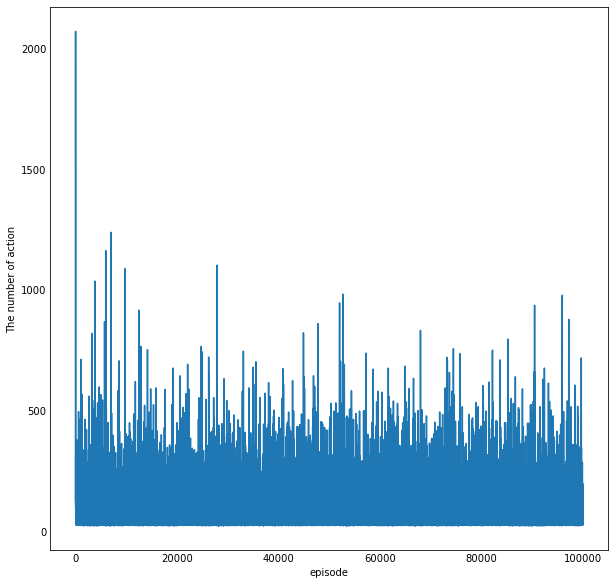

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# 定数
NB_EPISODE = 100000    # エピソード数
EPSILON = .1    # 探索率
ALPHA = .05      # 学習率
GAMMA = .90     # 割引率
ACTIONS = np.arange(4)  # 行動の集合
Result_V_values = {}

if __name__ == '__main__':
    grid_env = GridWorld()  # grid worldの環境の初期化
    ini_state = grid_env.start_pos  # 初期状態（エージェントのスタート地点の位置）
    # エージェントの初期化
    agent = VLearningAgent(
        alpha=ALPHA,
        gamma=GAMMA,
        epsilon=EPSILON,  # 探索率
        actions=ACTIONS,   # 行動の集合
        observation=ini_state,
        grid_map = grid_env.map)  # Q学習エージェント
    rewards = []    # 評価用報酬の保存
    actions = []    # 評価用でそのエピソードの行動回数を保存
    is_end_episode = False  # エージェントがゴールしてるかどうか？

    # 実験
    for episode in range(NB_EPISODE): #ゴールするまでが1エピソード
        #print("one episode")
        episode_reward = []  # 1エピソードの累積報酬
        while(is_end_episode == False):    # ゴールするまで続ける
            #print("position:", grid_env.agent_pos)
            action = agent.act(grid_env.agent_pos)  # 行動選択
            state, reward, is_end_episode = grid_env.step(action)
            while(reward is None): #rewardがNoneならずっと回す
                print("reward is None")
                action = agent.act(grid_env.agent_pos)  # 行動選択
                state, reward, is_end_episode = grid_env.step(action)
            #print("Action!", action)
            #print("observe:", state, reward)
            agent.observe(state, reward)   # 状態と報酬の観測
            episode_reward.append(reward)
        #rewards.append(np.sum(episode_reward))  # このエピソードの平均報酬を与える
        rewards.append(np.sum(episode_reward) / len(episode_reward))
        actions.append(len(episode_reward))
        state = grid_env.reset()  # 初期化
        agent.observe(state)    # エージェントを初期位置に
        is_end_episode = False
    Result_V_values = agent.v_values
    
    for state, v_value in agent.v_values.items():
        print(state, v_value)
    print(len(agent.v_values))
    # 結果のプロット
    plt.plot(np.arange(NB_EPISODE), actions)
    plt.xlabel("episode")
    plt.ylabel("The number of action")
#    plt.savefig("result.jpg")
    plt.show()

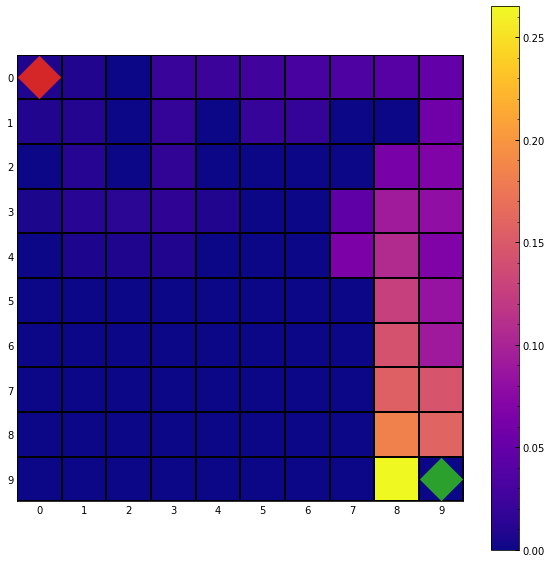

In [170]:
V_map = np.zeros(100).reshape(10, 10)
for state, v_value in agent.v_values.items():
    x = int(state[1])
    y = int(state[4])
    if(np.isnan(v_value)):
        V_map[y][x] = 0
    else:
        V_map[y][x] = v_value
plt.figure()
im = plt.imshow(V_map, aspect='equal', cmap="plasma");
plt.colorbar()
ax = plt.gca();
plt.rcParams["figure.figsize"] = [10,10]
ax.set_xticks(np.arange(0, 10, 1));
ax.set_yticks(np.arange(0, 10, 1));
plt.rcParams["xtick.top"] =False             # 上部に目盛り線を描くかどうか
plt.rcParams["xtick.bottom"] = False         # 下部に目盛り線を描くかどうか
plt.rcParams["ytick.left"] = False           # 左部に目盛り線を描くかどうか
plt.rcParams["ytick.right"] = False          # 右部に目盛り線を描くかどうか
ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
start = (0, 0)
goal = (9, 9)
plt.plot(start[1], start[0], "D", color="tab:red", markersize=30, label="start")
plt.plot(goal[1], goal[0], "D", color="tab:green", markersize=30, label="goal")


## 2. Q学習法

(0, 0) [       nan 0.08862938        nan 0.08862929]
(0, 1) [0.07976644        nan        nan 0.09847709]
(1, 1) [0.08862931 0.10941899 0.08862933        nan]
(1, 2) [0.09847706 0.12157665        nan        nan]
(1, 0) [       nan 0.09847709 0.07162115        nan]
(1, 3) [0.10941898 0.10940663 0.1093264  0.13508517]
(0, 3) [       nan 0.06985824        nan 0.12155886]
(0, 4) [0.                nan        nan 0.10532133]
(1, 4) [0.02960181        nan 0.06753694 0.12157624]
(2, 4) [0.12980584        nan 0.08716248 0.13508517]
(2, 3) [       nan 0.12157128 0.12153858 0.15009464]
(3, 4) [0.15009464        nan 0.10994061 0.10326099]
(4, 4) [0.12936675 0.         0.06350354        nan]
(4, 3) [       nan 0.05118725 0.15009456        nan]
(3, 3) [0.16677182 0.13508514 0.13508434 0.13508215]
(4, 5) [ 0.  0. nan nan]
(4, 6) [ 0. nan  0. nan]
(3, 6) [nan nan  0.  0.]
(2, 6) [nan nan  0.  0.]
(1, 6) [nan nan  0.  0.]
(0, 6) [nan  0. nan  0.]
(0, 7) [ 0.  0. nan nan]
(0, 8) [ 0.  0. nan  0.]
(1, 8

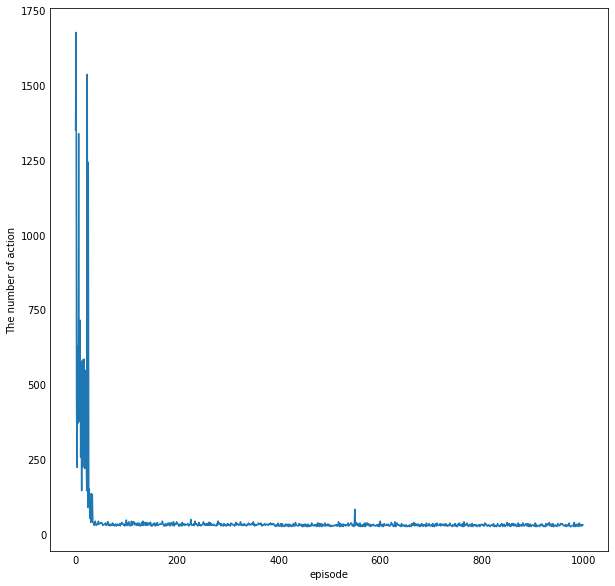

In [171]:
import numpy as np
import matplotlib.pyplot as plt

# 定数
NB_EPISODE = 1000    # エピソード数
EPSILON = .2    # 探索率
ALPHA = .3      # 学習率
GAMMA = .90     # 割引率
ACTIONS = np.arange(4)  # 行動の集合
Result_Q_values = {}

if __name__ == '__main__':
    grid_env = GridWorld()  # grid worldの環境の初期化
    ini_state = grid_env.start_pos  # 初期状態（エージェントのスタート地点の位置）
    # エージェントの初期化
    agent = QLearningAgent(
        alpha=ALPHA,
        gamma=GAMMA,
        epsilon=EPSILON,  # 探索率
        actions=ACTIONS,   # 行動の集合
        observation=ini_state)  # Q学習エージェント
    rewards = []    # 評価用報酬の保存
    actions = []    # 評価用でそのエピソードの行動回数を保存
    is_end_episode = False  # エージェントがゴールしてるかどうか？

    # 実験
    for episode in range(NB_EPISODE): #ゴールするまでが1エピソード
        episode_reward = []  # 1エピソードの累積報酬
        while(is_end_episode == False):    # ゴールするまで続ける
            #print("position:", grid_env.agent_pos)
            action = agent.act()  # 行動選択
            state, reward, is_end_episode = grid_env.step(action)
            while(reward is None): #rewardがNoneならずっと回す
                agent.set_wall(action, state)
                action = agent.act()  # 行動選択
                state, reward, is_end_episode = grid_env.step(action)
            #print("Action!", action)
            #print("observe:", state, reward)
            agent.observe(state, reward)   # 状態と報酬の観測
            episode_reward.append(reward)
        #rewards.append(np.sum(episode_reward))  # このエピソードの平均報酬を与える
        rewards.append(np.sum(episode_reward) / len(episode_reward))
        actions.append(len(episode_reward))
        state = grid_env.reset()  # 初期化
        agent.observe(state)    # エージェントを初期位置に
        is_end_episode = False
    Result_Q_values = agent.q_values
    
    for state, q_list in agent.q_values.items():
        print(state, q_list)
    print(len(agent.q_values))
    # 結果のプロット
    plt.plot(np.arange(NB_EPISODE), actions)
    plt.xlabel("episode")
    plt.ylabel("The number of action")
    plt.savefig("result.jpg")
    plt.show()

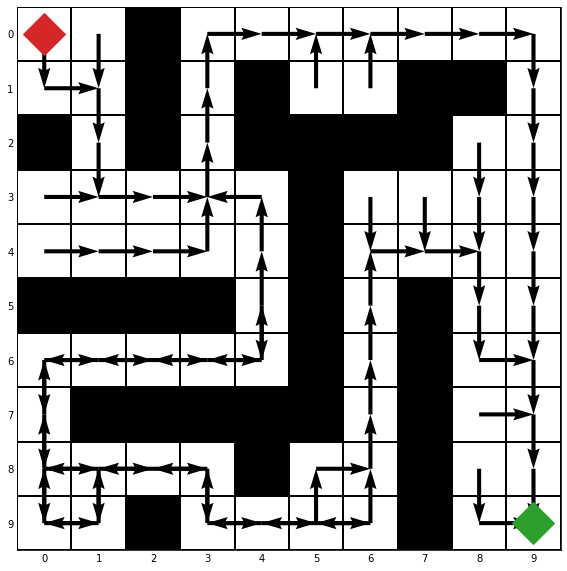

In [172]:
maze = np.array([[0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 2, 0, 2, 0, 0, 2, 2, 0],
                 [2, 0, 2, 0, 2, 2, 2, 2, 0, 0],
                 [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
                 [2, 2, 2, 2, 0, 2, 0, 2, 0, 0],
                 [0, 0, 0, 0, 0, 2, 0, 2, 0, 0],
                 [0, 2, 2, 2, 2, 2, 0, 2, 0, 0],
                 [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
                 [0, 0, 2, 0, 0, 0, 0, 2, 0, 0]])
#range(np.count_nonzero(np.where(maze == 2)[0][0]))
maze = np.where(maze == 2, 1, maze)
def plot_arrow(x1, y1, action):
    p = (y1, x1)
    if(action == 0):
        q = (y1-1, x1)
    elif(action == 1):
        q = (y1+1, x1)
    elif(action == 2):
        q = (y1, x1-1)
    elif(action == 3):
        q = (y1, x1+1)
    plt.quiver(p[1], p[0], (q[1]-p[1]), (q[0]-p[0]), angles='xy', scale_units='xy', scale=1)

plt.figure()
im = plt.imshow(maze, aspect='equal', cmap="gray_r");
ax = plt.gca();
plt.rcParams["figure.figsize"] = [10,10]

# Major ticks
ax.set_xticks(np.arange(0, 10, 1));
ax.set_yticks(np.arange(0, 10, 1));
plt.rcParams["xtick.top"] =False             # 上部に目盛り線を描くかどうか
plt.rcParams["xtick.bottom"] = False         # 下部に目盛り線を描くかどうか
plt.rcParams["ytick.left"] = False           # 左部に目盛り線を描くかどうか
plt.rcParams["ytick.right"] = False          # 右部に目盛り線を描くかどうか
# Labels for major ticks
#ax.set_xticklabels(np.arange(0, 10, 1));
#ax.set_yticklabels(np.arange(0, 10, 1));

# Minor ticks
ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
ax.set_yticks(np.arange(-.5, 10, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
start = (0, 0)
goal = (9, 9)
plt.plot(start[1], start[0], "D", color="tab:red", markersize=30, label="start")
plt.plot(goal[1], goal[0], "D", color="tab:green", markersize=30, label="goal")

#Q値からその場所での最適行動を記す
for position, q_list in Result_Q_values.items():
    x = int(position[1])
    y = int(position[4])
    index = np.where(q_list == np.nanmax(q_list))
    #print(x, y, index[0])
    if(x == 9 and y == 9):
        continue
    elif(len(index[0]) == 1):
        plot_arrow(x, y, index[0][0])
    elif(len(index[0]) > 1):
        for i in index[0]:
            plot_arrow(x, y, i)
    else:
        continue